# Проект - Прогнозирование температуры звезды.

В данной работе имитируется задача от обсерватории в построении нейросети для определения температуры на поверхности обнаруженных звезд. В предосавленной базе данных обсерватории для обучения есть240 звезд.

Характеристики:
* *Относительная светимость* **L/Lo** — светимость звезды относительно Солнца.
* *Относительный радиус* **R/Ro** — радиус звезды относительно радиуса Солнца.
* *Абсолютная звёздная величина* **Mv** — физическая величина, характеризующая блеск звезды.
* *Звёздный цвет* **(white, red, blue, yellow, yellow-orange и др.)** — цвет звезды, который определяют на основе спектрального анализа.
* *Тип звезды:*
|Тип звезды|	Номер, соответствующий типу|
|-|-|
|Коричневый карлик|	0|
|Красный карлик|	1|
|Белый карлик|	2|
|Звёзды главной последовательности| 	3|
|Сверхгигант|	4|
|Гипергигант|	5|
* *Абсолютная температура* **T(K)** — температура на поверхности звезды в Кельвинах. Это наш целевой признак.

In [ ]:
!pip install pandas==2.2.3 numpy==1.26.4 matplotlib==3.8.2 seaborn==0.13.2 scikit-learn==1.5.1 optuna imblearn -q

In [1]:
import pandas as pd
import numpy as np
import torch
import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
import torch.nn as nn
import random
import tqdm
import time

from math import log, ceil

from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.impute import SimpleImputer

from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from imblearn.over_sampling import SMOTENC
import optuna

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
# (seaborn ругается на grouped_data.get_group("key"))

In [2]:
df = pd.read_csv('6_class.csv')

In [3]:
# создавние класса для стилизации вывода с помощью команды print()
class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

In [4]:
RANDOM_STATE = 42 # фиксация зерна датчика случайных чисел

In [5]:
# функция для предвариетельного знакомства с таблицей(-ами)
def data_viewer(**dfs):
    for name, dfr in dfs.items():
        print(color.BOLD + color.BLUE + color.UNDERLINE, 'Информация по таблице', name)
        display(dfr.head(5))
        print('Количество пропусков в таблице:' + color.BOLD, dfr.isna().sum().sum(), color.END)
        dups = dfr.duplicated().sum().sum()
        print('Количество явных дубликатов в таблице:', dfr.duplicated().sum().sum())
        print()
        print(dfr.info())
        print()
        print(color.BOLD + color.BLUE + color.UNDERLINE, 'Распределение признаков методом describe')
        display(dfr.describe())

# функция для проврки уникальных значений качественных признаков
# я ее использую, чтобы наглядно посмотреть есть ли неявные дубликаты
def unique_check(**dfs):
    for df_name, df in dfs.items():
        categorical = df.select_dtypes('O').columns
        for column in categorical:
            unique_list = df.loc[~df[column].isna(), column].unique()
            print(f'{color.BOLD}Датафрейм {color.BLUE}{df_name}{color.END}{color.BOLD}. \
            \nКолонка {color.BLUE}{column}{color.END + color.BOLD} - ее уникальные значения {color.END}{(sorted(unique_list))}. \
            \nВсего уникальных значений {len(unique_list)}.\n')
        print()

rng = None

def set_seed(seed=RANDOM_STATE):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    global rng
    rng = np.random.default_rng(seed)

In [6]:
set_seed()

## Загрузка исходных данных из файла

In [7]:
data_viewer(df=df)

 Информация по таблице df


,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,0,3068,0.002400,0.1700,16.12,0,Red
1,1,3042,0.000500,0.1542,16.60,0,Red
2,2,2600,0.000300,0.1020,18.70,0,Red
3,3,2800,0.000200,0.1600,16.65,0,Red
4,4,1939,0.000138,0.1030,20.06,0,Red


Количество пропусков в таблице: 0 
Количество явных дубликатов в таблице: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              240 non-null    int64  
 1   Temperature (K)         240 non-null    int64  
 2   Luminosity(L/Lo)        240 non-null    float64
 3   Radius(R/Ro)            240 non-null    float64
 4   Absolute magnitude(Mv)  240 non-null    float64
 5   Star type               240 non-null    int64  
 6   Star color              240 non-null    object 
dtypes: float64(3), int64(3), object(1)
memory usage: 13.3+ KB
None

 Распределение признаков методом describe


,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type
count,240.00000,240.000000,240.000000,240.000000,240.000000,240.000000
mean,119.50000,10497.462500,107188.361635,237.157781,4.382396,2.500000
std,69.42622,9552.425037,179432.244940,517.155763,10.532512,1.711394
min,0.00000,1939.000000,0.000080,0.008400,-11.920000,0.000000
25%,59.75000,3344.250000,0.000865,0.102750,-6.232500,1.000000
50%,119.50000,5776.000000,0.070500,0.762500,8.313000,2.500000
75%,179.25000,15055.500000,198050.000000,42.750000,13.697500,4.000000
max,239.00000,40000.000000,849420.000000,1948.500000,20.060000,5.000000


## Исследовательский анализ

Пропущенные значения и явные дубликаты отсутствуют. Сразу можно отметить большую разницу между минимальным и максимальным значением относительной светимости и радиуса. Связано это с тем, что указаны значения относительно известной звезды - Солнца. Возможно стоит логарифмировать эти признаки, чтобы "сжать" данные.

Переименую названия колонок для более удобного взаимодействия с талицей.

In [8]:
df = df.drop('Unnamed: 0', axis=1).set_axis(['temperature', 'luminosity', 'radius', 'magnitude', 'star_type', 'star_color'], axis='columns')

Проверю на наличие неявных дубликатов

In [9]:
unique_check(df=df)

Датафрейм df.             
Колонка star_color - ее уникальные значения ['Blue', 'Blue ', 'Blue White', 'Blue white', 'Blue white ', 'Blue-White', 'Blue-white', 'Orange', 'Orange-Red', 'Pale yellow orange', 'Red', 'White', 'White-Yellow', 'Whitish', 'Yellowish', 'Yellowish White', 'white', 'yellow-white', 'yellowish'].             
Всего уникальных значений 19.




Можно заметить большое количество неявных дубликатов. Устриним их.

In [10]:
df['star_color'] = df['star_color'].map(lambda x:x.replace(' ', '-').strip(' -')).str.lower()

In [11]:
unique_check(df=df)

Датафрейм df.             
Колонка star_color - ее уникальные значения ['blue', 'blue-white', 'orange', 'orange-red', 'pale-yellow-orange', 'red', 'white', 'white-yellow', 'whitish', 'yellow-white', 'yellowish', 'yellowish-white'].             
Всего уникальных значений 12.




Количество уникальных значений уменьшилось, однако все еще остались похожие значения по типу бело-желтый или желто-белый.

In [12]:
custom_mapping = {
    'whitish': 'white',
    'yellowish-white': 'yellow-white',
    'white-yellow':'yellow-white',
    'pale-yellow-orange': 'orange',
    'orange-red': 'orange'
}

In [13]:
df['star_color'] = df['star_color'].replace(custom_mapping)

In [14]:
category_feature = ['star_type', 'star_color']
quantitative_feature = ['temperature', 'luminosity', 'radius', 'magnitude']

In [15]:
palette = {
    "red": "red",
    "blue": "blue",
    "blue-white": "lightblue",  # голубовато-белый
    "yellow-white": "lightyellow",
    "white": "white",
    "yellowish":"yellow",
    "orange": "orange"
}

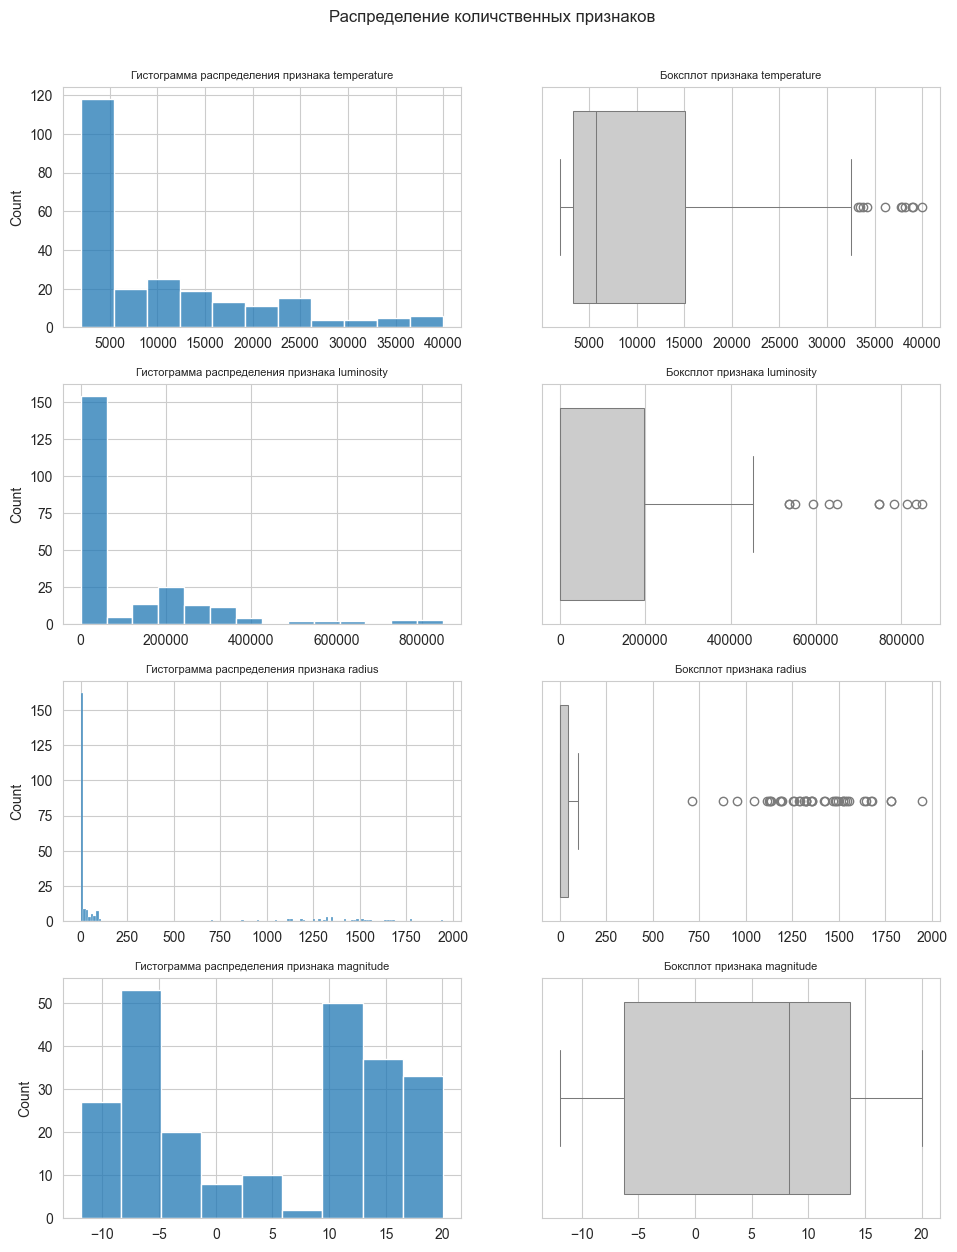

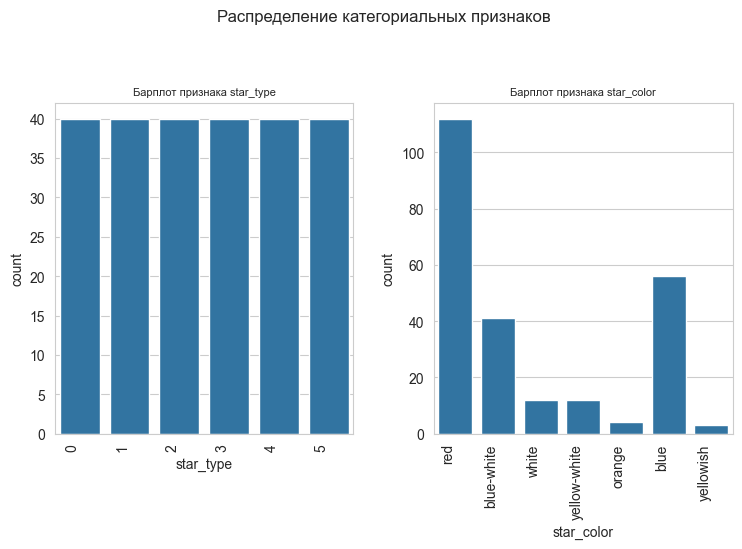

In [16]:
fig, axs = plt.subplots(4, 2, figsize=(10, 13))
fig.suptitle('Распределение количственных признаков')
fig.tight_layout(pad=3, h_pad=2)

for i, param in enumerate(quantitative_feature):
    sns.histplot(data=df, x=param, ax=axs[i, 0])
    axs[i, 0].set_title(f'Гистограмма распределения признака {param}', fontsize=8)
    sns.boxplot(data=df, x=param, ax=axs[i, 1], color=".8", linewidth=.75, orient='h')
    axs[i, 1].set_title(f'Боксплот признака {param}', fontsize=8)        
    axs[i, 0].set_xlabel('')
    axs[i, 1].set_xlabel('')

fig, axs = plt.subplots(1, 2, figsize=(8, 5))
fig.suptitle('Распределение категориальных признаков')
fig.tight_layout(pad=3, h_pad=2)

for i, param in enumerate(category_feature):
    sns.countplot(data=df, x=param, ax=axs[i])
    axs[i].set_title(f'Барплот признака {param}', fontsize=8)
    axs[i].set_xticks(ticks=axs[i].get_xticks(), labels=axs[i].get_xticklabels(), rotation=90, ha='right')

Теперь уже визуально можно отметить распределение признаков светимости, радиуса и температуры. Сразу можно отметить, что данных по звездам с большой температурой меньше, так что, вероятно, и нейросеть с ними будет справляться хуже. Больше всего информации о звездах меньше солнца и с температурой <=5000К.

In [17]:
df['radius'] = df['radius'].map(lambda x: log(x))
df['luminosity'] = df['luminosity'].map(lambda x: log(x))

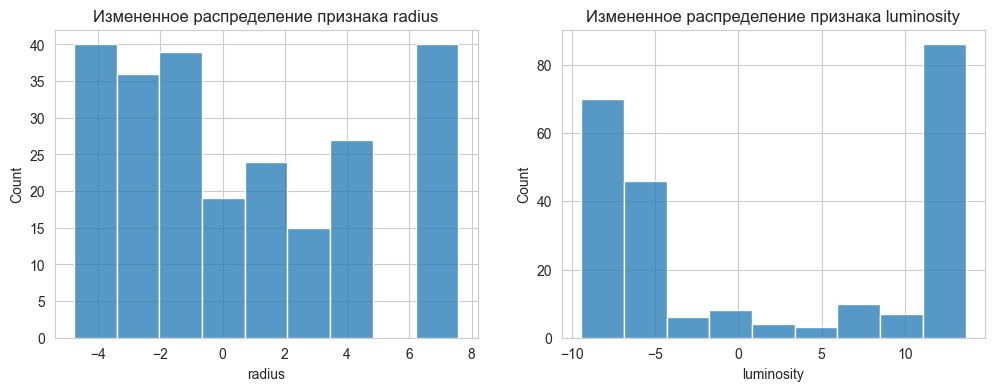

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(data=df, x=df['radius'], ax=axs[0])
axs[0].set_title('Измененное распределение признака radius')
sns.histplot(data=df, x=df['luminosity'], ax=axs[1])
axs[1].set_title('Измененное распределение признака luminosity')
plt.show()

## Вывод:
Для обучения представлены 240 изученых звезд. Пропущенные значения, как и явные дубликаты отсутуют. Неявные дубликаты обработаны в признаке цвета звезды. Поскольку имеется неоднородность данных по этому признаку, я бы попробовал сгенерировать больше данных в обучающей выборке. Тажке было произведено логарифмирование признаков светимости и радиуса звезд

## Подготовка данных к построению модели

Определим категориальные и количественные признаки, произведем разделение на обучающую и тестовую выборки в размере 70/30 %.

In [19]:
ohe_cols = ['star_type', 'star_color']
num_cols = ['luminosity', 'radius', 'magnitude']

In [20]:
ohe_pipe = Pipeline([
    (
        'simpleimputer_ohe', 
         SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    ),
    (
        'ohe', 
        OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
    )
])

preprocessing = ColumnTransformer([
    ('ohe', ohe_pipe, ohe_cols),
    ('num', StandardScaler(), num_cols)
], remainder='passthrough')

In [21]:
X = df.drop(columns=['temperature'])
y = df['temperature']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=RANDOM_STATE, stratify=X['star_color'])

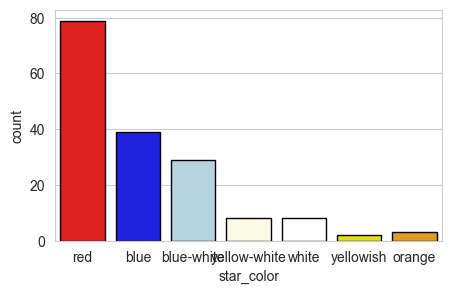

In [22]:
plt.figure(figsize=(5, 3))
ax = sns.countplot(data=X_train, x="star_color", hue="star_color", palette=palette,order=palette.keys(), legend=False)
for bar in ax.patches:
    bar.set_edgecolor("black")

In [23]:
set_seed()
X_train = torch.FloatTensor(preprocessing.fit_transform(X_train))
X_test = torch.FloatTensor(preprocessing.transform(X_test))
y_train = torch.FloatTensor(y_train.values).reshape(-1, 1)
y_test = torch.FloatTensor(y_test.values).reshape(-1, 1)

## Построение простой модели нейронной сети

In [24]:
class Net(nn.Module):
    def __init__(self, n_neurons):
        super(Net, self).__init__()
        self.layers = nn.ModuleList()
        set_seed()
        self.layer_params = [n_neurons]
        for i in range(len(n_neurons) - 2):
            # выбор слоя
            layer = nn.Linear(n_neurons[i], n_neurons[i+1])
            # выбор функции активации
            act_func = nn.ReLU()

            self.layers.append(layer)
            self.layers.append(act_func)

        self.layers.append(nn.Linear(n_neurons[-2], n_neurons[-1]))
        self.layers.append(act_func)
        
        set_seed()
        for layer in self.layers:
            if type(layer) == nn.Linear:
                nn.init.kaiming_uniform_(layer.weight, mode='fan_in', nonlinearity='relu')
                nn.init.normal_(layer.bias, mean=0.5, std=1)
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [25]:
def NN_model_training(net, 
                      X_train, X_test, y_train, y_test, 
                      loss_func=None,
                      batch_size=50, 
                      learning_rate=1.0e-3,
                      num_epochs=1000, 
                      patience=70,
                      delta_patience=50,
                      early_stopping=True,
                      printing=True,
                      plot=True):

    set_seed() 
    start_time = time.time()
    
    epoch_train_res = []
    epoch_test_res = []

    best_test_rmse = float('inf')
    best_train_rmse = float('inf')
    best_net = type(net)(*net.layer_params)
    epochs_without_improvement = 0

    if loss_func == None:
        return print('Отсутствует лосс функция')

    optimizer = torch.optim.Adam(net.parameters(), learning_rate)

    
    num_batches = ceil(len(X_train)/batch_size)
    accumulation_step = num_epochs//num_batches 
    '''''
    С помощью введения параметра accumulation_step я попытался ввести 
    динмическую оптимизацию шага по мере увеличения количества пройденных эпох
    '''''
    
    # ======= тут начинается обучение модели по эпохам ======
    for epoch in tqdm.trange(num_epochs):
        net.train()
        order = np.random.permutation(len(X_train))
        for batch_idx in range(num_batches):
            start_index = batch_idx * batch_size
            batch_index = order[start_index: start_index + batch_size]
            X_batch = X_train[batch_index]
            y_batch = y_train[batch_index]

            preds = net.forward(X_batch)
            loss_value = loss_func(preds, y_batch)
            loss_value.backward()

            
            accumulation_iteration = 1 + epoch//accumulation_step
            if ((batch_idx + 1) % accumulation_iteration == 0) or (batch_idx + 1 == num_batches):
                optimizer.step()
                optimizer.zero_grad()

        set_seed()
        net.eval()
        with torch.no_grad():
            train_preds = net.forward(X_train)
            test_preds = net.forward(X_test)
            rmse_train = torch.sqrt(loss_func(train_preds, y_train)).item()
            rmse_test = torch.sqrt(loss_func(test_preds, y_test)).item()
        
        epoch_train_res.append(rmse_train)
        epoch_test_res.append(rmse_test)
        
        # ==== механизм Early_stopping ======
        if early_stopping:
            if rmse_test < best_test_rmse - 1e-4:
                best_test_rmse = rmse_test
                best_train_rmse = rmse_train

                best_net.load_state_dict(net.state_dict())
                
                epochs_without_improvement = 0
            else:
                epochs_without_improvement += 1
                if epochs_without_improvement >= patience:
                    if printing:
                        print(f"\n⏹ Early stopping: {patience} эпох без улучшения")
                    break
    
    end_time = time.time()
    
    if plot:
        plt.figure(figsize=(5,3))
        plt.plot(epoch_train_res)
        plt.plot(epoch_test_res)
        plt.legend(['train', 'test'])
        plt.title('Прогресс обучения', fontsize=14)
        plt.ylabel('результат RMSE')
        plt.xlabel('количество эпох')

    if printing:
        print(f'В результате работы модели лучшие результаты {color.BOLD}RMSE{color.END} на: \
        \n{color.BOLD}{color.UNDERLINE} Тренировочных данных{color.END} {round(best_train_rmse)} \
        \n{color.BOLD}{color.UNDERLINE} Тестовых данных{color.END} {round(best_test_rmse)}')
        print('Время обучения нейросети:', round(end_time-start_time, 3), 'секунд')
    return best_net

Для обучения нейронной сети задаим две модели с различной архитектурой. 
1) простая нейросеть с одним скрытым слоем в 100 нейронов
2) более сложная нейростеь в 3 скрытыми слоями по 100 нейронов.

100%|█████████████████████████████████████████████████████████████████████████████| 1300/1300 [00:08<00:00, 150.56it/s]


В результате работы модели лучшие результаты RMSE на:         
 Тренировочных данных 3583         
 Тестовых данных 3881
Время обучения нейросети: 10.838 секунд


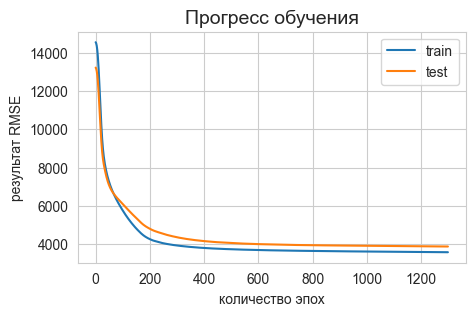

In [26]:
net_1 = Net([14, 100, 1])
net_1 = NN_model_training(net_1, 
                        X_train, X_test, y_train, y_test,
                        batch_size=30,
                        num_epochs=1300,
                        loss_func=torch.nn.MSELoss(),
                        learning_rate=3*10**(-2),
                        patience=100,
                        delta_patience=30)

100%|███████████████████████████████████████████████████████████████████████████████| 600/600 [00:05<00:00, 105.43it/s]


В результате работы модели лучшие результаты RMSE на:         
 Тренировочных данных 3450         
 Тестовых данных 3777
Время обучения нейросети: 5.708 секунд


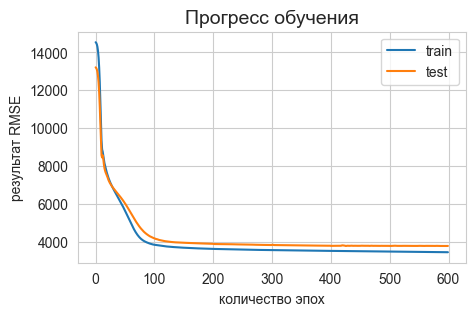

In [27]:
net_2 = Net([14, 100, 100, 100, 1])
net_2 = NN_model_training(net_2, 
                        X_train, X_test, y_train, y_test,
                        batch_size=30,
                        num_epochs=600,
                        loss_func=torch.nn.MSELoss(),
                        learning_rate=3*10**(-3),
                        patience=100,
                        delta_patience=30)

Более сложная модель показала результаты значительно лучше, чем простая, поэтому она будет выбрана основной.

In [29]:
net_2.eval()
net_2_preds = net_2.forward(X_test)
loss_func = torch.nn.MSELoss()
net_2_rmse = torch.sqrt(loss_func(net_2_preds, y_test)).item()
print(f'Результат лучшей неросети на тестовой выборке {net_2_rmse}K')

Результат лучшей неросети на тестовой выборке 3776.98291015625K


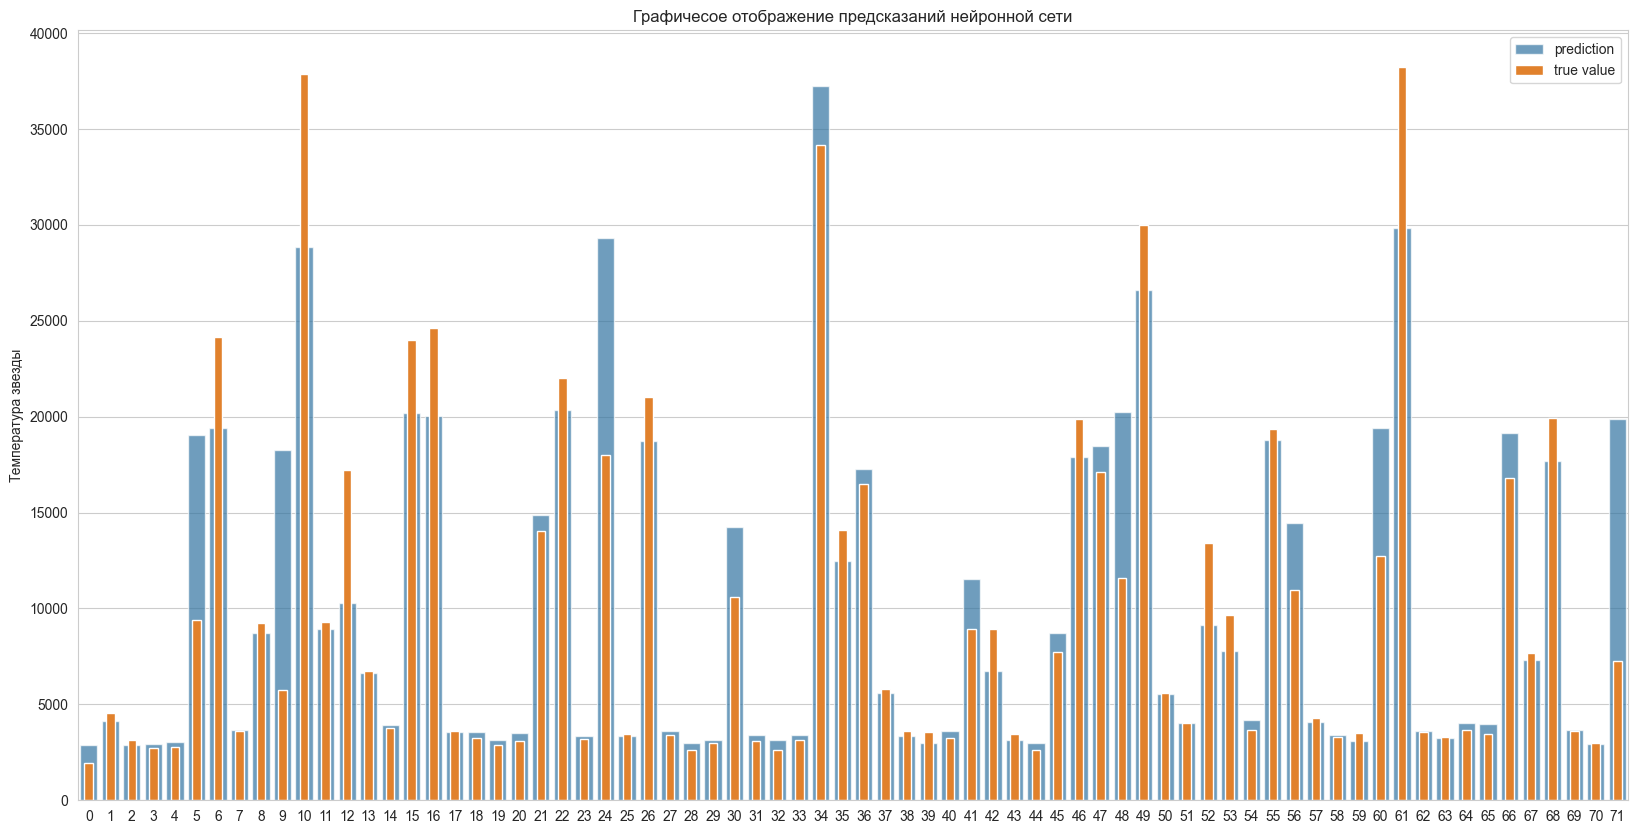

In [30]:
plt.figure(figsize=(20,10))
sns.barplot(net_2_preds.flatten().detach().numpy(), alpha=0.7, label='prediction')
sns.barplot(y_test.flatten().detach().numpy(), width=0.4, label='true value')
plt.title('Графичесое отображение предсказаний нейронной сети')
plt.ylabel('Температура звезды')
plt.legend()
plt.show()

Ожидаемо модель гораздо лучше српавляется с предсказанием звезд с температурой менее 5000К, гораздо ей сложнее дается предсказывать высокую температуру звезд. Модель примерно поровну ошибается как в меньшую, так и в большую сторону. 

## Улучшение сети

На данном этапе создадим новый класс нейросети Net_with_regularisation(), которая будет применять Batch Normalization и Dropout к скрытым слоям.

In [31]:
class Net_with_regularisation(nn.Module):
    def __init__(self, n_neurons, drop_size=0):
        super(Net_with_regularisation, self).__init__()
        set_seed()
        self.layers = nn.ModuleList()
        self.layer_params = [n_neurons, drop_size]
        for i in range(1, len(n_neurons) - 1):
            # выбор слоя
            layer = nn.Linear(n_neurons[i-1], n_neurons[i])
            # выбор функции активации
            act_func = nn.ReLU()

            batch_layer = nn.BatchNorm1d(n_neurons[i])
            drop_layer = nn.Dropout(p=drop_size)

            self.layers.append(layer)
            self.layers.append(batch_layer)
            self.layers.append(act_func)
            self.layers.append(drop_layer)

        self.layers.append(nn.Linear(n_neurons[-2], n_neurons[-1]))
        self.layers.append(act_func)

        for layer in self.layers:
            if type(layer) == nn.Linear:
                nn.init.kaiming_uniform_(layer.weight, mode='fan_in', nonlinearity='relu')
                nn.init.normal_(layer.bias, mean=0.5, std=1)
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

 91%|███████████████████████████████████████████████████████████████████████▋       | 408/450 [00:03<00:00, 120.87it/s]



⏹ Early stopping: 100 эпох без улучшения
В результате работы модели лучшие результаты RMSE на:         
 Тренировочных данных 4198         
 Тестовых данных 4329
Время обучения нейросети: 3.38 секунд


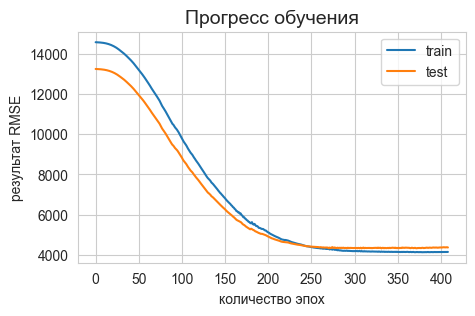

In [32]:
net_3 = Net_with_regularisation([14, 100, 1],
                                drop_size=0.2)
net_3 = NN_model_training(net_3, 
                        X_train, X_test, y_train, y_test,
                        batch_size=40,
                        num_epochs=450,
                        loss_func=torch.nn.MSELoss(),
                        learning_rate=8*10**(-3),
                        patience=100,
                        delta_patience=30)

 86%|████████████████████████████████████████████████████████████████████▌           | 257/300 [00:03<00:00, 82.19it/s]



⏹ Early stopping: 100 эпох без улучшения
В результате работы модели лучшие результаты RMSE на:         
 Тренировочных данных 4711         
 Тестовых данных 4647
Время обучения нейросети: 3.133 секунд


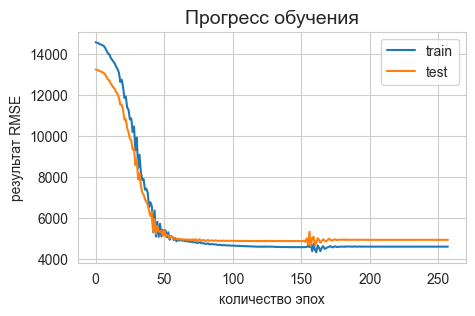

In [33]:
net_4 = Net_with_regularisation([14, 100, 100, 100, 1],
                               drop_size=0.2)
net_4 = NN_model_training(net_4, 
                        X_train, X_test, y_train, y_test,
                        batch_size=50,
                        num_epochs=300,
                        loss_func=torch.nn.MSELoss(),
                        learning_rate=4*10**(-2),
                        patience=100,
                        delta_patience=30)

После введения Batch Normalization и Dropout результаты моделей не улучшились, а наоборот - ухудшились. 

В задаче сказано что необходимо реализовать автоматический перебор параметров нейросети. Ниже будет показан код для подбора скорости обучения, процент "отключаемых" нейронов в слое и размер батча с помощь optuna. Запускать я его не буду, просто исползую полученные с его помощью гиперпарметры.

 76%|████████████████████████████████████████████████████████████▌                   | 227/300 [00:02<00:00, 80.73it/s]



⏹ Early stopping: 70 эпох без улучшения
В результате работы модели лучшие результаты RMSE на:         
 Тренировочных данных 3834         
 Тестовых данных 3490
Время обучения нейросети: 2.818 секунд


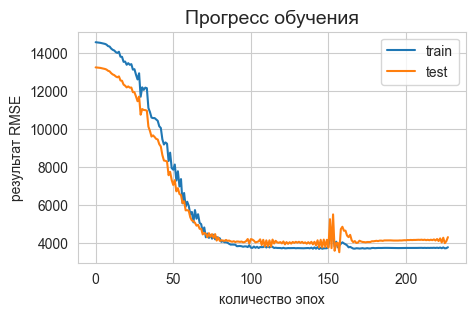

In [34]:
net = Net_with_regularisation([14, 100, 100, 100, 1], drop_size=0.02124928239834989)
best_model = NN_model_training(net, 
                               X_train, X_test, y_train, y_test,
                               loss_func=torch.nn.MSELoss(),
                               batch_size=42,
                               learning_rate=0.025478183776666195,
                               num_epochs=300,
                               patience=70,
                               delta_patience=30)

In [35]:
best_model.eval()
best_model_preds = best_model.forward(X_test)
loss_func = torch.nn.MSELoss()
rmse_best = torch.sqrt(loss_func(best_model_preds, y_test)).item()
rmse_best

3489.513427734375

На тесте модель показала 3489.5 К - данный показатель удовлетваряет условию заказчика в RMSE <= 4500 К. Ниже представлено визуальное отображения результатов предсказания модели.

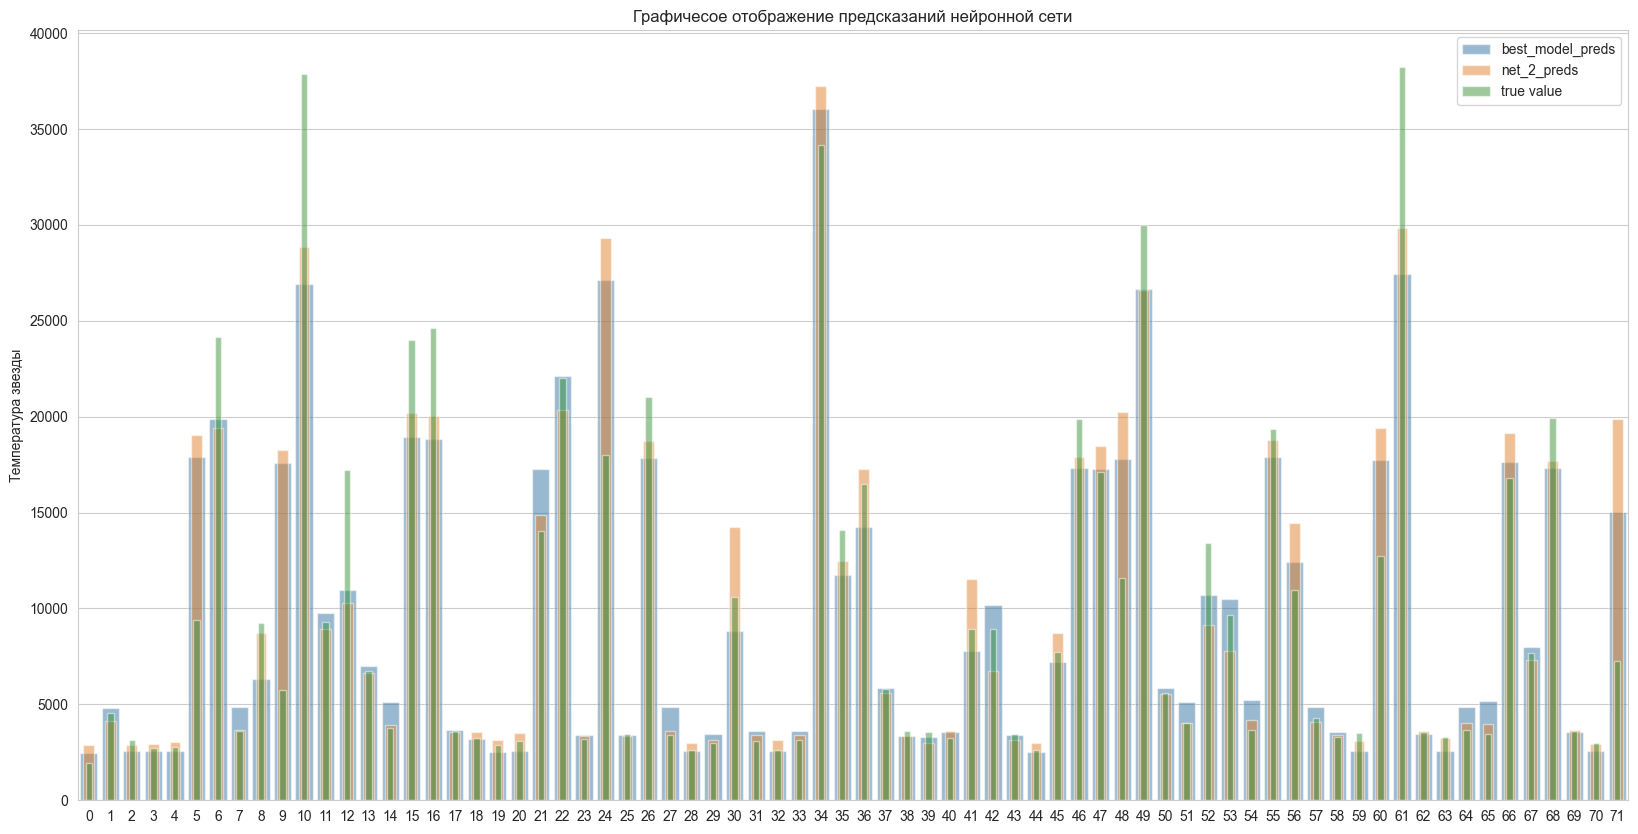

In [36]:
plt.figure(figsize=(20,10))
sns.barplot(best_model_preds.flatten().detach().numpy(), alpha=0.5, width=0.8, label='best_model_preds')
sns.barplot(net_2_preds.flatten().detach().numpy(), alpha=0.5, width=0.5, label='net_2_preds')
sns.barplot(y_test.flatten().detach().numpy(), alpha=0.5, width=0.3, label='true value')
plt.title('Графичесое отображение предсказаний нейронной сети')
plt.ylabel('Температура звезды')
plt.legend()
plt.show()

Обе модели делают похожие ошибки. Значительное изменение предсказаний можно заметить по звездам №30, 71. В звездах №5, 9, 60, 24 модель с регуляризацией все также сильно ошибается, выдавая завышенные предсказания, но уже меньше, чем можель без регуляризации. Скорее всего и звезды это одинаковые, что можно проверить:

In [37]:
pd.DataFrame(X_test.detach().numpy(), columns=preprocessing.get_feature_names_out()).iloc[[10, 61]]

,ohe__star_type_1,ohe__star_type_2,ohe__star_type_3,ohe__star_type_4,ohe__star_type_5,ohe__star_color_blue-white,ohe__star_color_orange,ohe__star_color_red,ohe__star_color_white,ohe__star_color_yellow-white,ohe__star_color_yellowish,num__luminosity,num__radius,num__magnitude
10,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.174014,1.754303,-1.145326
61,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.165458,1.682904,-1.288305


Действительно, обе звезды оказались синие сверхгиганты. Также можно предположить что звезды № 5 и 9 тоже одинаковые, и модель ошиблась на них одинаково.

In [38]:
pd.DataFrame(X_test.detach().numpy(), columns=preprocessing.get_feature_names_out()).iloc[[5, 9]]

,ohe__star_type_1,ohe__star_type_2,ohe__star_type_3,ohe__star_type_4,ohe__star_type_5,ohe__star_color_blue-white,ohe__star_color_orange,ohe__star_color_red,ohe__star_color_white,ohe__star_color_yellow-white,ohe__star_color_yellowish,num__luminosity,num__radius,num__magnitude
5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.190609,0.997669,-1.066639
9,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.153626,0.994994,-1.033053


Результат, однако, странный, потому что в обучающей выборке звезд 4 типа и синего цвета было аж 22 штуки.

## Вывод

В результате работы были исследованые данные предоставленные обсерваторией. Пропущенные значения и явные дубликаты отсутствовали, обработы неявные дубликаты в признаке цвета звезды. Также были логарифмированы признаки светимости и радуса звезд.

При отборе моделей выбрана была модель со следующей архитектурой:
* 14 входных нейронов (по количеству признаков);
* первый скрытый слой с 100 нейронов;
* второй скрытый слой с 100 нейронов;
* третий скрытый слой с 100 нейронов;
* выходной слой с 1 нейроном.

Далее реализован класс нейросети с использованием Batch Normalization и Dropout. На графиках, визуализирующих процесс обучения, видно, Batch Normalization и Dropout помогают сократить разрыв в показателях модели на тренировочной и валидационной выборке. С помощью optuna подобраны параметры нейросети. Итоговая нейросеть показала результат RMSE 3489 К на тестовой выборке.

Значительно улучшить модель поможет увеличение количества данных, особенно для тех категорий звезд, которые находятся в меньшинстве.